# Loading images from the Quick Draw Dataset 2k examples


get the data at https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Dense, Dropout, Flatten,Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

import tensorflow as tf
import pandas as pd
import os
import pickle
import numpy as np

Using TensorFlow backend.


In [3]:
print(keras.__version__)
print(tf.__version__)

2.0.5
1.3.0


In [4]:
num_examples_per_class = 2000

classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe',
                  'banana','bandage','barn','baseball bat','baseball','basket',
                  'basketball','bathtub','beach','bear','beard','bed','bee','belt',
                  'bicycle','binoculars','birthday cake','blueberry',
                  'book','boomerang','bottlecap','bowtie','bracelet','brain',
                  'bread','broom','bulldozer','bus','bush','butterfly','cactus','cake']

In [5]:
len(classes)

40

## Load the image data from scratch

Only use if you are downloading the raw data and doing it yourself

In [ ]:
#This cell is only if you are loading the data from scratch
# get the data 
quickdraws = [np.load("../../data/{}.npy".format(qdraw))[:num_examples_per_class] for qdraw in classes]

# Concat the arrays together
x_data = np.concatenate(quickdraws,axis=0)

x_data.shape

In [5]:
np.save('x_data_40_classes_2k.npy',x_data)

## Use this cell to load the premade datasets that I made

In [7]:
x_data = np.load("./data/x_data_40_classes_2k.npy")

In [8]:
x_data.shape

(80000, 784)

## Lets make some labels for our data

In [9]:
labels = [np.full((num_examples_per_class,), classes.index(qdraw)) for qdraw in classes]

## Concat the arrays together
y_data = np.concatenate(labels,axis=0)
y_data.shape

(80000,)

In [10]:
print(x_data.shape)
print(y_data.shape)

(80000, 784)
(80000,)


## lets look at the Images 

In [11]:
def show_object(obj):
    # Reshape 784 array into 28x28 image
    image = obj.reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(image, cmap='gray_r')
    plt.show()

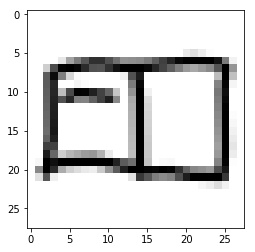

26
book


In [12]:
show_object(x_data[53000])
print(y_data[53000])
print (classes[y_data[53000]])

In [16]:
#shuffling function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [17]:
x_data,y_data = unison_shuffled_copies(x_data,y_data)

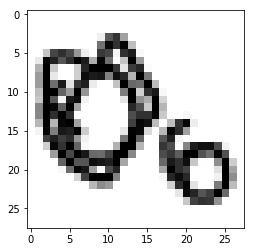

25
blueberry


In [18]:
show_object(x_data[0])
print (y_data[0])
print (classes[y_data[0]])

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2 )

img_rows = 28
img_cols = 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (64000, 28, 28, 1)
64000 train samples
16000 test samples


In [20]:
# convert class vectors to binary class matrices
num_classes = 40
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [21]:
Inp=Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3), activation='relu',name = 'Conv_01')(Inp)
x = Conv2D(64, (3, 3), activation='relu',name = 'Conv_02')(x)
x = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool_01')(x)
x = Dropout(0.25,name = 'Dropout_01')(x)
x = Flatten(name = 'Flatten_01')(x)
x = Dense(128, activation='relu',name = 'Dense_01')(x)
x = BatchNormalization()(x)
x = Dropout(0.5,name = 'Dropout_02')(x)
output = Dense(num_classes, activation='softmax',name = 'Dense_02')(x)

In [28]:

Inp = Input(shape=input_shape,name = 'Input_layer')

#ConvBlock 01
conv01 = Conv2D(32, (3, 3), padding='same',activation = 'relu', input_shape=Inp.shape,name = 'Conv01_layer')(Inp)
conv02 = Conv2D(32, (3, 3),activation = 'relu',name = 'Conv02_layer')(conv01)
maxpool_01 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool01_layer')(conv02)
drop01 = BatchNormalization()(maxpool_01)
#drop01 = Dropout(0.25,name = 'Dropout01_layer')(drop01)

#Convblock 02
conv03 = Conv2D(64, (3, 3), padding='same',activation = 'relu',name = 'Conv03_layer')(drop01)
conv04 = Conv2D(64, (3, 3),activation = 'relu',name = 'Conv04_layer')(conv03)
maxpool_02 = MaxPooling2D(pool_size=(2, 2),name = 'MaxPool02_layer')(conv04)
drop02 = BatchNormalization()(maxpool_02)
drop02 = Dropout(0.25,name = 'Dropout02_layer')(drop02)


# Fully Connected Dense block
x = Flatten(name = 'Flatten_layer')(drop02)
x = Dense(512, activation='relu',name = 'Dense01_layer')(x)
x = BatchNormalization()(x)
x = Dropout(0.5,name = 'Dropout03_layer')(x)
logits_layer = Dense(num_classes, name= 'logits_layer')(x)
output = Activation('softmax',name = 'Sofftmax_layer')(logits_layer)

In [29]:
model = Model(Inp,output)

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
Conv01_layer (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
Conv02_layer (Conv2D)        (None, 26, 26, 32)        9248      
_________________________________________________________________
MaxPool01_layer (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
Conv03_layer (Conv2D)        (None, 13, 13, 64)        18496     
_________________________________________________________________
Conv04_layer (Conv2D)        (None, 11, 11, 64)        36928     
__________

In [31]:
#opt = keras.optimizers.rmsprop()
opt = keras.optimizers.Adadelta()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

In [32]:
batch_size = 128
epochs = 10

In [33]:
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 310s - loss: 2.0135 - acc: 0.4982 - val_loss: 2.3986 - val_acc: 0.3634
Epoch 2/10
64000/64000 [==============================] - 298s - loss: 1.2654 - acc: 0.6636 - val_loss: 0.9729 - val_acc: 0.7369
Epoch 3/10
64000/64000 [==============================] - 299s - loss: 1.0461 - acc: 0.7180 - val_loss: 0.8955 - val_acc: 0.7576
Epoch 4/10
64000/64000 [==============================] - 282s - loss: 0.9242 - acc: 0.7480 - val_loss: 0.8462 - val_acc: 0.7704
Epoch 5/10
64000/64000 [==============================] - 262s - loss: 0.8344 - acc: 0.7711 - val_loss: 0.8044 - val_acc: 0.7782
Epoch 6/10
64000/64000 [==============================] - 284s - loss: 0.7685 - acc: 0.7871 - val_loss: 0.7975 - val_acc: 0.7795
Epoch 7/10
64000/64000 [==============================] - 300s - loss: 0.7239 - acc: 0.7989 - val_loss: 0.7452 - val_acc: 0.7947
Epoch 8/10
64000/64000 [=======================

In [36]:
# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate(x_test, y_test,
          batch_size=batch_size)
print('Model Accuracy = %.2f' % (evaluation[1]))
print('Model Loss = %.2f' % (evaluation[0]))

16000/16000 [==============================] - 22s    
Model Accuracy = 0.80
Model Loss = 0.72


In [35]:
preds = model.predict(x_test)

In [34]:
pd.concat([pd.DataFrame(y_train).mean(), pd.DataFrame(y_test).mean()], axis=1)

,0,1
0,0.024594,0.026625
1,0.025250,0.024000
2,0.025344,0.023625
3,0.025078,0.024688
4,0.025141,0.024438
5,0.025047,0.024813
6,0.024766,0.025937
7,0.025094,0.024625
8,0.025313,0.023750
9,0.025047,0.024813


In [69]:
def get_topn_preds(itemid, n=5):
    print (classes[np.where(y_test[itemid]==1)[0][0]])
    return (sorted(zip(preds[itemid], classes), reverse=True)[:n])

In [70]:
get_topn_preds(0)

ant


[(0.9568345, 'ant'),
 (0.014659992, 'bandage'),
 (0.0076032807, 'airplane'),
 (0.004216772, 'bee'),
 (0.0026155228, 'bowtie')]

In [71]:
get_topn_preds(1)

bus


[(0.92013717, 'bus'),
 (0.022080785, 'ambulance'),
 (0.016726423, 'bulldozer'),
 (0.012242624, 'bear'),
 (0.0082468167, 'bottlecap')]

In [82]:
from sklearn.metrics import confusion_matrix
y_preds = preds.argmax(axis=-1)
y_true = y_test.argmax(axis=-1)
cnf_mat = confusion_matrix(y_preds, y_true )

In [90]:
np.set_printoptions(threshold=np.inf)

print(cnf_mat)

[[371   0   0   2   6   7   0   0   1   1   2   2   1   0   0   1  10   6
    1   1   4   2   1   2   0   2   0   1   1   2   2   1   1   2   0   1
    0   1   5   0]
 [  1 317   1   2   0   0  16   0   0   0   1   0   0   0   1   2   1  27
    3   0   2   3   0   3   2  28   0   1   2   0   4   3   1   1   0   0
    1   2   0   0]
 [  1   1 320   1   0   3   0   0   0   0   1   0   1   0   0   0   0   1
    0   0   0   5   0   1   0   0   0   0   0   0   4   0   0   0  10  20
    1   1   0   0]
 [  1   3   0 333   5   1   0   4   1   1   0   0   2   0   1   0   3   7
    0   1   3   0   0   1   1   3   0   0   3   1   4   1   0   1   1   0
    0   3   2   1]
 [  0   3   0   2 313   1   0   0   0   0   1   0   1   1   1   1  10   7
    1   2   7   1   0   2   1   3   0   1   0   2   6   0   1   0   1   1
    2   5   0   0]
 [  3   0   0   1   1 351   0   0   0   1   0   1   0   0   0   1   4   1
    0   1   0   6   0   0   0   0   0   5   1   0   1   0   3   0   0   0
    1   0   0   0

In [92]:
classes[-16]

'birthday cake'